In [2]:
import torch
import pandas as pd
import altair as alt
from torchviz import make_dot

# Adding complexity to our linear model

Let's go back to our regression example.

In [5]:
p = 5 
n = 100

x = torch.randn(n, p) # predictors (n observations, p features)
y = torch.randn(n, 1) # outcomes (n observations)

In [6]:
loss_record = [] 
β = torch.randn(p+1,1) 
β.requires_grad_() 

for e in range(500):
    ŷ = torch.matmul(x, β[1:]) + β[0]
    L = torch.sum((y-ŷ)**2)/n 
    
    L.backward() # compute gradients 
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        β -= 10e-5 * β.grad
        β.grad.zero_()

Remember that the linear model is $\hat y =x\beta_{1:p} + \beta_0$. Let's say we want to add some complexity to this model by figuring out if there are some other predictors we can build (call them $z$) that are a transformation of the predictors $x$ that are better for predicting $y$ in a linear model than $x$ is. To do that, we'll first let $z = g(xW + b)$ with $W$ being a $p \times h$ matrix and $b$ a $1 \times h$ matrix so each row of $z$ ends up with $h$ columns and $g$ is an element-wise ReLU function. The purpose of $W$ and $b$ is to make $h$ predictors out of our original $p$ using a linear transformation. The purpose of $g$ is to add complexity to the model.

Let's dig into this, one step at a time. First we'll investigate the transformation $xW$. As we said, we're trying to build new features from our old features, so let's look at just one of these new features, $z_1$:

$$ 
z_1 
=
\left[
\begin{array}{c}
z_{11} \\ z_{12} \\ \vdots \\ z_{1n}
\end{array}
\right]
=
g\left(
\left[
\begin{array}{c}
x_{11} & x_{21} & \cdots & x_{p1} \\
x_{12} & x_{22} & \cdots & x_{p2} \\
\vdots & \vdots & \ddots & \vdots \\
x_{1n} & x_{2n} & \cdots & x_{pn}
\end{array}
\right]
\left[
\begin{array}{c}
w_{11} \\ w_{12} \\ \vdots \\ w_{1p}
\end{array}
\right]
+
b_1
\right)
$$

Graphically, this looks exactly like logistic regression, but with the $\sigma()$ replaced by $g()$. We also renamed the parameters and output, but that's just cosmetic, not consequential.

<img src="images/greg.png" width="250"> 

Since we'll be using this structure again and again we'll just abbreviate it as follows:

<img src="images/greg-abbrev.png" width="130">

Notice that it's implicit here that $w_1$ is a vector of parameters that is being dot-multiplied by the vector $x$, $b_1$ is being added, and then the result is being transformed by some function $g$ (omitted in the drawing). 

Now let's zoom back out to our full matrix equation $z = g(xW+b)$. One way to look at this is that we're doing $h$ "$g$-linear" regressions (assuming we have $W$ and $b$) and getting their predictions. The matrix equation $z = g(xW+b)$ expresses all of these "regressions" simultaneously.

In [7]:
from torch.nn.functional import relu as g
h = 10
W = torch.randn(5, h).requires_grad_()
b = torch.randn(1, h).requires_grad_()

In [8]:
z = g(torch.matmul(x,W) + b)
z.shape

torch.Size([100, 10])

As you see, we're getting 100 observations of 10 "features". Let's look at one of them:

In [9]:
z[0:10,1]

tensor([0.3226, 1.4233, 2.8091, 2.2245, 1.0566, 4.0743, 3.2438, 3.3498, 2.9763,
        3.0156], grad_fn=<SelectBackward>)

We could also have done them one-at-a-time:

In [10]:
w1 = W[:,1]
b1 = b[:,1]
z1 = g(torch.matmul(x,w1) + b1)

In [11]:
z1[0:10]

tensor([0.3226, 1.4233, 2.8091, 2.2245, 1.0566, 4.0743, 3.2438, 3.3498, 2.9763,
        3.0156], grad_fn=<SliceBackward>)

Same thing. 

The graphical representation of this is:

<img src="images/2layer.png" width="150">

One way to think about $z$ is as a different "representation" of what's in $x$. If we're predicting whether an image is a cat or a dog based on the pixel values $x$, then $z$ will perhaps learn to encode something like the number of red pixels, whether or not there are triangles in the image, etc. Ultimately the two representations contain the same information since $z$ is just a transformation of $x$, but somehow we're looking at that information in a different way, or highlighting different aspects of it.

Now our final model is a linear model done on the new predictors $z$. That model is $\hat y =z\alpha_{1:h} + \alpha_0$. I'm calling the coefficient vector $\alpha$ because now this needs $h$ coefficients (plus 1 intercept) for each of the $h$ new features, whereas $\beta$ was a $p$-length vector. So, in full, our model is now $\hat y = g(xW+b)\alpha_{1:h} + \alpha_0$. 

In [12]:
α = torch.randn(h+1,1).requires_grad_()
ŷ = torch.matmul(z,α[1:]) + α[0]

<img src="images/net.png" width="300">

Note that without the ReLU (or some nonlinear function) between $x$ and $z$, there is always a vector $\beta$ such that $x\beta_{1:p} + \beta_0 = (xW+b)\alpha_{1:h} + \alpha_0$ for every $W$, $b$, and $\alpha$. In effect, adding the transformation $W$ doesn't actually add anything to the model- we're expanding the number of parameters to fit without actually expanding the expressivity of the model because there is always a model  with fewer parameters that perfectly captures the predictions of the over-parametrized model. That is why the nonlinearity $g$ is necessary.

---

**EXERCISE:** 

Let's say we have
    
$$
W = 
\left[
\begin{array}{ccc}
1 & 1 & 1 \\
1 & 2 & 3
\end{array}
\right]    
\quad
b = 
\left[
\begin{array}{ccc}
0 & 0 & 0
\end{array}
\right]
\\
\alpha_{1:3} = 
\left[
\begin{array}{c}
1 \\ -1 \\ 0
\end{array}
\right]
\quad
\alpha_0 = 0
\notag
$$
    
Find $\beta$ so that $x\beta_{1:2} + \beta_0 = (xW+b)\alpha_{1:3} + \alpha_0$ no matter what $x$ is.

---

Finally, we can compute our MSE loss:

In [13]:
L = torch.sum((y-ŷ)**2)/n
L

tensor(48.5825, grad_fn=<DivBackward0>)

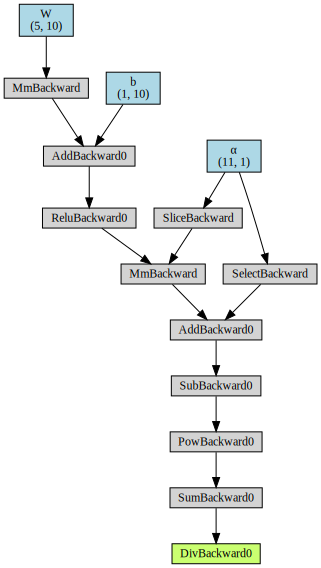

In [14]:
make_dot(L, {'W':W, 'b':b, 'α':α})

Now $L$ depends both on what $W$ and $b$ are and on what $\alpha$ is. In other words, both of these sets of coefficients are parameters of the model that we can tweak and optimize. $W$ and $b$ determine what kinds of "new predictors" we get out $x$, while $\alpha$ puts those new features together into the final prediction. What's amazing is that we can fit all of these parameters simultaneously using gradient descent: just update both sets of parameters using the negative gradient at each step. Note that this model has $h\times (p+1) + h+1$ total parameters (the values of $W_{ij}$, $b_j$, and $\alpha_j$) to be fit, whereas our original linear model only had $p+1$ parameters.  

Furthermore, this poses no problem for pytorch:

In [15]:
L.backward()

In [16]:
α.grad

tensor([[ -6.4595],
        [-16.7796],
        [-15.1167],
        [ -7.9075],
        [  2.7765],
        [-15.6188],
        [-20.2843],
        [  4.3777],
        [-11.5368],
        [  4.3241],
        [-14.3780]])

In [17]:
W.grad

tensor([[ 5.1586,  3.4025, -4.2722, -0.2403,  0.3381,  4.2296, -0.4710,  4.3947,
         -0.2808,  1.8277],
        [-0.4474, -1.0875, -0.0434, -0.0232, -0.0903, -1.4003, -0.1300, -0.8659,
          0.5523, -0.5326],
        [ 9.8471,  9.7235, -7.9455, -0.3419,  0.7284, 10.8695, -1.0256, 10.4540,
         -4.5601,  5.0058],
        [-9.0001, -6.7283,  9.8864,  0.1835, -0.5037, -7.8525,  0.4590, -7.5906,
          1.9053, -4.3163],
        [-3.4535, -4.5699,  4.6391,  0.2171, -0.3337, -3.6184,  0.5009, -4.5248,
          1.9277, -1.9886]])

In [18]:
b.grad

tensor([[10.0408,  6.4187, -6.2048,  0.2272,  0.5346,  9.7377, -0.2559, 10.1649,
          0.6104,  3.4241]])

### Looping

As before, now that we have gone through this once, we can put it all together into a loop:

In [19]:
p = 5 
n = 100

x = torch.randn(n, p) # predictors (n observations, p features)
y = torch.randn(n, 1) # outcomes (n observations)

In [20]:
h = 10
W = torch.randn(5, h).requires_grad_()
b = torch.randn(1, h).requires_grad_()
α = torch.randn(h+1, 1).requires_grad_()
loss_record = []

for e in range(500):
    z = g(torch.matmul(x,W)+b)
    ŷ = torch.matmul(z,α[1:]) + α[0]
    L = torch.sum((y-ŷ)**2)/n
    
    L.backward() # compute gradients (in this case δL/δα, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        α -= 10e-3 * α.grad
        α.grad.zero_()
        W -= 10e-3 * W.grad
        W.grad.zero_()
        b -= 10e-3 * b.grad
        b.grad.zero_()

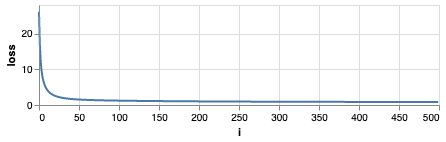

In [21]:
loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df, height=100).mark_line().encode(x='i', y='loss')

And here are our predictions for a new $x$:

In [22]:
new_x = torch.randn(10, 5) # 10 new observations
z = g(torch.matmul(new_x,W)+b)
torch.matmul(z,α[1:])+α[0]

tensor([[-0.3466],
        [-0.5659],
        [-0.2962],
        [-0.6167],
        [-0.0182],
        [ 0.3881],
        [ 0.1251],
        [ 0.1841],
        [-0.0748],
        [ 0.2099]], grad_fn=<AddBackward0>)

---

**EXERCISE** 

Apply this strategy to our logistic regression to make a more complex **classification** model. In other words, implement the machine learning algorithm with these characteristics:
* Model: $\hat p_i = \sigma(g(x_i W+b))\alpha_{1:h} + \alpha_0)$, with $\sigma$, $g$, $W$, $b$, and $\alpha$ as previously described
* Loss: log-loss
* Search Algorithm: gradient descent

---

### Conclusion

We just developed a machine learning method out of these three components:
* "linear-relu" $\times$ 10 + linear model (model)
* MSE loss (loss)
* gradient descent (search algorithm)

This is a neural network. The 10 "new predictors" are together a _hidden layer_ (hidden because we don't see them at the end of the day, just the output $\hat y$) and each of them individually is called a _hidden unit_. The "layer" terminology comes from the graphical representation, where the successive hidden representations look like successive layers that the information passes through while being transformed from predictors to prediction:

<img src="images/net-layers.png" width="300">

So, in the language of neural networks or deep learning, what we've built is a network with input of size 5, one linear hidden layer of size 10, ReLU *activation function*, and a linear output layer of size 1.

## How does this help?

While we could define ever-more complex interactions of parameters and data, it turns out that simply stacking linear regressions with nonlinear activation functions on top of each other (e.g. "linear-relu" regressions) gets us enough complexity to model practically any relationship we want. Let's have a look at an example where $y = x^2$ in reality:

In [23]:
p = 1
n = 100

x = torch.randn(n, p) # predictors (n observations, p features)
y = (x[:,0]**2).unsqueeze(dim=1) # outcomes (n observations)

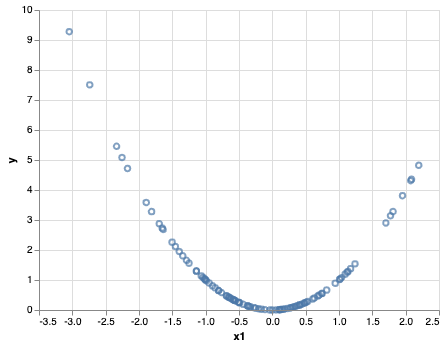

In [24]:
data = pd.DataFrame({'y':y[:,0], 'x1':x[:,0]})
alt.Chart(data).mark_point().encode(x='x1', y='y')

If we fit a linear model, we don't do very well:

In [25]:
loss_record = [] 
β = torch.randn(p+1,1).requires_grad_()
b = torch.randn(1).requires_grad_()

for e in range(500):
    ŷ = torch.matmul(x, β[1:]) + β[0] # ŷ = xβ + b(calculate predictions)
    L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)² (use predictions to calculate loss)
    
    L.backward() # compute gradients (in this case δL/δβ, δL/δW)
    loss_record.append(L.item())

    with torch.no_grad(): # take the gradient descent step 
        β -= 10e-2 * β.grad
        β.grad.zero_()

The loss does go down, but overall it's still really high:

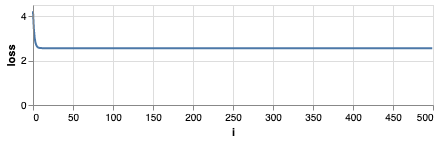

In [26]:
loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df, height=100).mark_line().encode(x='i', y='loss')

And when we plot the model predictions against reality we see how bad it is:

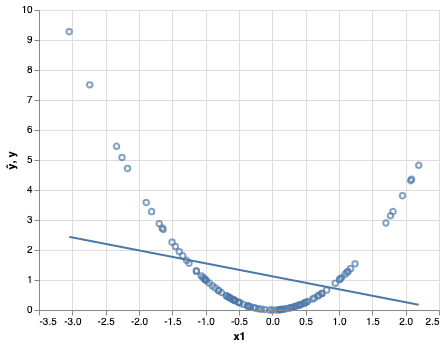

In [27]:
preds = pd.DataFrame({'ŷ':ŷ.detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

However, we can introduce a hidden layer (of size 10):

In [28]:
h = 10
W = torch.randn(p, h).requires_grad_()
b = torch.randn(1, h).requires_grad_()
α = torch.randn(h+1, 1).requires_grad_()
loss_record = []
ϵ = 10e-3

for e in range(500):
    z = g(torch.matmul(x,W) + b)
    ŷ = torch.matmul(z,α[1:]) + α[0]
    L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)² (use predictions to calculate loss)
    
    L.backward() # compute gradients (in this case δL/δα, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        α -= ϵ * α.grad
        α.grad.zero_()
        W -= ϵ * W.grad
        W.grad.zero_()
        b -= ϵ * b.grad
        b.grad.zero_()

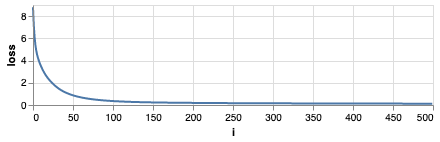

In [29]:
loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df, height=100).mark_line().encode(x='i', y='loss')

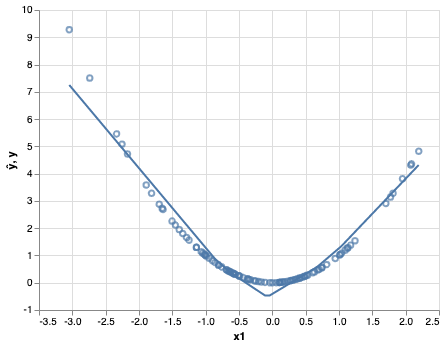

In [30]:
preds = pd.DataFrame({'ŷ':ŷ.detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

And now the loss is lower and the fit is clearly much improved. 

---
**EXERCISE** 

Plot $z_1$ vs $x$. Repeat for each $z_j$. What do you see? 
    
Now make plots of each $z_j$ vs. $y$. Is the relationship between each $z_j$ and $y$ closer to linear than the relationship between $x$ and $y$? Does this explain why the linear regression $\hat y = \alpha_{1:h} z + \alpha_0$ produces a better fit than the linear regression $\hat y = \beta_{1:p} x + \beta_0$?

---

**EXERCISE** 

Change the value of $h$ in the code above so that hidden layer has size 3 instead of 10. How does that change the fit? What if you set $h=100$? 

---

**EXERCISE** 

When fitting linear models, it's a common practice to break continuous variables up into categories. For instance, let's say we're predicting someone's weight based on their age. Instead of modeling $\text{weight} = \beta_0 + \beta_1 \times \text{age}$, we could break age up into 10 categories (say: age < 10 years, 10 < age < 20,... 90 < age) and fit our model using those categories as predictors instead. Basically, we have a set of regions $A = \{(0,10],(10,20],\dots (90,\infty]\}$ and our new variables are $z_j = I_{A_j}(x)$ where $I_{A_j}$ is the indicator function that returns 1 if $x \in A_j$ and 0 otherwise. Now we're modeling $\text{weight} = \alpha_0 + \alpha_1 z_1 + \dots \alpha_{10} z_{10}$ instead of $\text{weight} = \beta_0 + \beta_1 \times \text{age}$.
    
Considering a population including both adults and children, do you think the relationship between age and weight will be linear? What will that mean if we try to fit the model $\text{weight} = \beta_0 + \beta_1 \times \text{age}$?
    
How is this problem addressed by transforming $x$ into 10 new predictors $z_j$ using the indicator functions? What is the relationship between any $z_j$ and $y$?
    
How does this relate to our neural networks?
    
----

## Conclusion

We saw how we can get a nonlinear fit out of stacking linear models and nonlinear activation functions together.